
# Permutation Importance vs Random Forest Feature Importance (MDI)

In this example, we will compare the impurity-based feature importance of
:class:`~sklearn.ensemble.RandomForestClassifier` with the
permutation importance on the titanic dataset using
:func:`~sklearn.inspection.permutation_importance`. We will show that the
impurity-based feature importance can inflate the importance of numerical
features.

Furthermore, the impurity-based feature importance of random forests suffers
from being computed on statistics derived from the training dataset: the
importances can be high even for features that are not predictive of the target
variable, as long as the model has the capacity to use them to overfit.

This example shows how to use Permutation Importances as an alternative that
can mitigate those limitations.

.. topic:: References:

   * :doi:`L. Breiman, "Random Forests", Machine Learning, 45(1), 5-32,
     2001. <10.1023/A:1010933404324>`


## Data Loading and Feature Engineering
Let's use pandas to load a copy of the titanic dataset. The following shows
how to apply separate preprocessing on numerical and categorical features.

We further include two random variables that are not correlated in any way
with the target variable (``survived``):

- ``random_num`` is a high cardinality numerical variable (as many unique
  values as records).
- ``random_cat`` is a low cardinality categorical variable (3 possible
  values).



In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
rng = np.random.RandomState(seed=42)
X["random_cat"] = rng.randint(3, size=X.shape[0])
X["random_num"] = rng.randn(X.shape[0])

categorical_columns = ["pclass", "sex", "embarked", "random_cat"]
numerical_columns = ["age", "sibsp", "parch", "fare", "random_num"]

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [2]:
X_train

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
1216,3,female,Q,1,NaN,0,0,7.7333,-0.436386
819,3,female,Q,2,NaN,0,0,7.7500,2.006093
1286,3,female,C,2,38.0,0,0,7.2292,0.521122
1280,3,male,S,1,22.0,0,0,7.8958,-2.135674
761,3,male,S,0,16.0,0,0,9.5000,1.607346
...,...,...,...,...,...,...,...,...,...
872,3,female,S,0,NaN,0,0,8.0500,0.766080
777,3,male,S,0,19.0,0,0,8.0500,2.601683
423,2,male,S,0,34.0,0,0,13.0000,0.346488
668,3,male,S,0,22.0,0,0,8.0500,0.949554


We define a predictive model based on a random forest. Therefore, we will make
the following preprocessing steps:

- use :class:`~sklearn.preprocessing.OrdinalEncoder` to encode the
  categorical features;
- use :class:`~sklearn.impute.SimpleImputer` to fill missing values for
  numerical features using a mean strategy.



In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

categorical_encoder = OneHotEncoder(handle_unknown='ignore')

numerical_pipe = SimpleImputer(strategy="mean")

preprocessing = ColumnTransformer(
    [
        ("Codificación de Categóricas", categorical_encoder, categorical_columns),
        ("Transformación de numéricas", numerical_pipe, numerical_columns),
    ],
    verbose_feature_names_out=False,
)

random_forest = RandomForestClassifier(random_state=42)

flujo = Pipeline(
    [
        ("Preprocesamiento", preprocessing),
        ("Clasificador", random_forest),
    ]
)
flujo.fit(X_train, y_train)

Pipeline(steps=[('Preprocesamiento',
                 ColumnTransformer(transformers=[('Codificación de Categóricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('Transformación de numéricas',
                                                  SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('Clasificador', RandomForestClassifier(random_state=42))])

In [5]:
primer_paso=flujo['Preprocesamiento']
primer_paso.get_feature_names_out()

array(['pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'random_cat_0',
       'random_cat_1', 'random_cat_2', 'age', 'sibsp', 'parch', 'fare',
       'random_num'], dtype=object)

In [7]:
primer_paso.transform(X_train)

array([[  0.        ,   0.        ,   1.        , ...,   0.        ,
          7.7333    ,  -0.43638589],
       [  0.        ,   0.        ,   1.        , ...,   0.        ,
          7.75      ,   2.00609289],
       [  0.        ,   0.        ,   1.        , ...,   0.        ,
          7.2292    ,   0.52112243],
       ...,
       [  0.        ,   1.        ,   0.        , ...,   0.        ,
         13.        ,   0.34648848],
       [  0.        ,   0.        ,   1.        , ...,   0.        ,
          8.05      ,   0.94955414],
       [  1.        ,   0.        ,   0.        , ...,   2.        ,
        151.55      ,   0.93567839]])

In [15]:
import pandas as pd
DF=pd.DataFrame(primer_paso.transform(X_train), columns=primer_paso.get_feature_names_out())

## Accuracy of the Model
Prior to inspecting the feature importances, it is important to check that
the model predictive performance is high enough. Indeed there would be little
interest of inspecting the important features of a non-predictive model.

Here one can observe that the train accuracy is very high (the forest model
has enough capacity to completely memorize the training set) but it can still
generalize well enough to the test set thanks to the built-in bagging of
random forests.

It might be possible to trade some accuracy on the training set for a
slightly better accuracy on the test set by limiting the capacity of the
trees (for instance by setting ``min_samples_leaf=5`` or
``min_samples_leaf=10``) so as to limit overfitting while not introducing too
much underfitting.

However let's keep our high capacity random forest model for now so as to
illustrate some pitfalls with feature importance on variables with many
unique values.



In [16]:
print(f"RF train accuracy: {flujo.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {flujo.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.814


## Tree's Feature Importance from Mean Decrease in Impurity (MDI)
The impurity-based feature importance ranks the numerical features to be the
most important features. As a result, the non-predictive ``random_num``
variable is ranked as one of the most important features!

This problem stems from two limitations of impurity-based feature
importances:

- impurity-based importances are biased towards high cardinality features;
- impurity-based importances are computed on training set statistics and
  therefore do not reflect the ability of feature to be useful to make
  predictions that generalize to the test set (when the model has enough
  capacity).

The bias towards high cardinality features explains why the `random_num` has
a really large importance in comparison with `random_cat` while we would
expect both random features to have a null importance.

The fact that we use training set statistics explains why both the
`random_num` and `random_cat` features have a non-null importance.



In [17]:
flujo[-1]

RandomForestClassifier(random_state=42)

In [18]:
import pandas as pd

feature_names = flujo[0:1].get_feature_names_out()

mdi_importances = pd.Series(
    flujo[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)

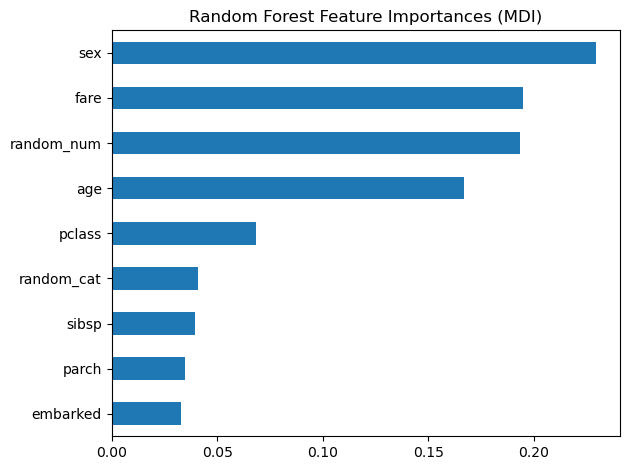

In [19]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

As an alternative, the permutation importances of ``rf`` are computed on a
held out test set. This shows that the low cardinality categorical feature,
`sex` and `pclass` are the most important feature. Indeed, permuting the
values of these features will lead to most decrease in accuracy score of the
model on the test set.

Also note that both random features have very low importances (close to 0) as
expected.



In [20]:
### remember that pipeline create a predict method that is the last step of the pipeline

y_pred = flujo.predict(X_test)
y_pred

array(['0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '1', '1', '0',
       '0', '0', '1', '0', '0', '0', '1', '1', '0', '1', '0', '1', '1',
       '0', '0', '0', '1', '0', '0', '0', '0', '1', '1', '0', '1', '0',
       '0', '1', '0', '0', '0', '0', '1', '0', '1', '0', '0', '1', '0',
       '1', '0', '0', '1', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '0', '1',
       '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '0', '0', '1',
       '1', '1', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0',
       '0', '0', '1', '0', '0', '1', '0', '0', '0', '1', '0', '0', '1',
       '1', '0', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '1',
       '1', '1', '0', '0', '1', '1', '0', '1', '0', '1', '0', '0', '0',
       '1', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '0', '1', '1',
       '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '0', '0

In [21]:
X_test

,pclass,sex,embarked,random_cat,age,sibsp,parch,fare,random_num
1177,3.0,male,S,2,NaN,8.0,2.0,69.5500,0.919154
271,1.0,male,S,1,24.0000,1.0,0.0,82.2667,-0.691908
330,2.0,male,S,0,57.0000,0.0,0.0,13.0000,0.895193
1157,3.0,male,S,0,18.0000,1.0,1.0,20.2125,0.287124
395,2.0,female,S,1,18.0000,0.0,1.0,23.0000,0.477041
...,...,...,...,...,...,...,...,...,...
40,1.0,male,C,0,NaN,0.0,0.0,39.6000,0.114228
240,1.0,male,S,0,45.0000,0.0,0.0,26.5500,0.607897
204,1.0,female,C,1,NaN,1.0,0.0,82.1708,2.526932
359,2.0,male,S,0,0.8333,0.0,2.0,29.0000,1.573987


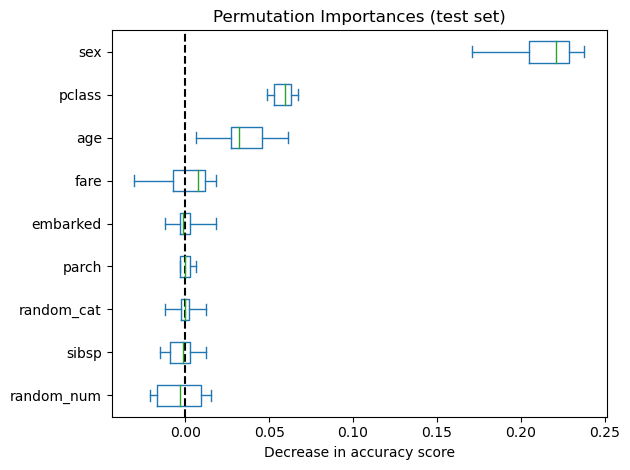

In [23]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    flujo, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

It is also possible to compute the permutation importances on the training
set. This reveals that `random_num` and `random_cat` get a significantly
higher importance ranking than when computed on the test set. The difference
between those two plots is a confirmation that the RF model has enough
capacity to use that random numerical and categorical features to overfit.



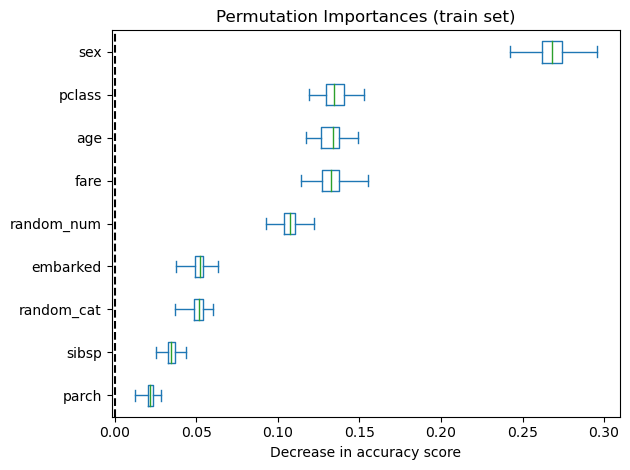

In [24]:
result = permutation_importance(
    flujo, X_train, y_train, n_repeats=100, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

We can further retry the experiment by limiting the capacity of the trees
to overfit by setting `min_samples_leaf` at 20 data points.



In [26]:
flujo.set_params(Clasificador__min_samples_leaf=20).fit(X_train, y_train)

Pipeline(steps=[('Preprocesamiento',
                 ColumnTransformer(transformers=[('Codificación de Categóricas',
                                                  OrdinalEncoder(encoded_missing_value=-1,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['pclass', 'sex', 'embarked',
                                                   'random_cat']),
                                                 ('Transformación de numéricas',
                                                  SimpleImputer(),
                                                  ['age', 'sibsp', 'parch',
                                                   'fare', 'random_num'])],
                                   verbose_feature_names_out=False)),
                ('Clasificador',
                 RandomForestClassifier(min_samples_leaf=20, random_state=42))])

Observing the accuracy score on the training and testing set, we observe that
the two metrics are very similar now. Therefore, our model is not overfitting
anymore. We can then check the permutation importances with this new model.



In [27]:
print(f"RF train accuracy: {flujo.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {flujo.score(X_test, y_test):.3f}")

RF train accuracy: 0.810
RF test accuracy: 0.832


In [28]:
train_result = permutation_importance(
    flujo, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
test_results = permutation_importance(
    flujo, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_importances_idx = train_result.importances_mean.argsort()

In [29]:
train_importances = pd.DataFrame(
    train_result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
test_importances = pd.DataFrame(
    test_results.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

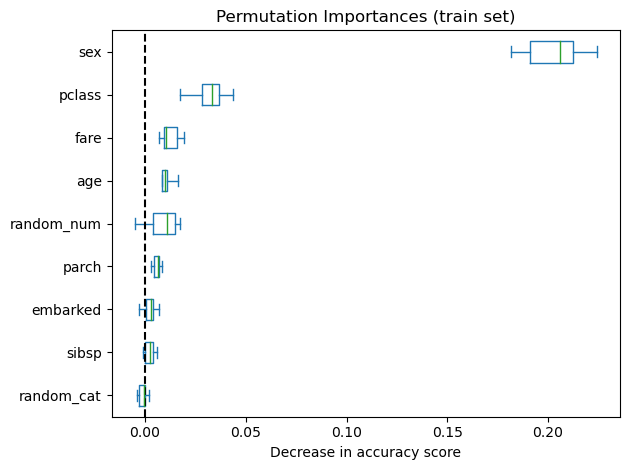

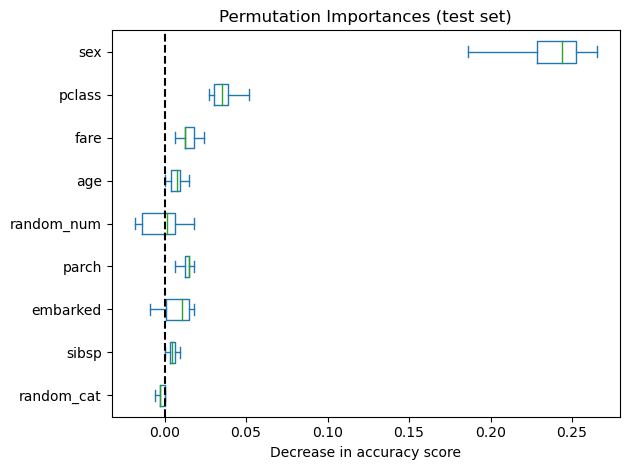

In [30]:
for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()

Now, we can observe that on both sets, the `random_num` and `random_cat`
features have a lower importance compared to the overfitting random forest.
However, the conclusions regarding the importance of the other features are
still valid.

